In [30]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

def nba_sal(url, filename):

    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Referer': 'https://google.com'
    }
    response2018 = requests.get(url, headers = headers)
    soup2018 = BeautifulSoup(response2018.content, 'html.parser')
    table = soup2018.find('table', class_='hh-salaries-ranking-table')
    salaries = []
    players = []
    for row in table.find_all('tr'):
        player_name = row.find('td', class_='name').get_text(strip=True)
        table_elements = row.find_all('td')
        player_salary = None
        if len(table_elements)>3:
            player_salary = table_elements[3].get_text(strip=True)
        if player_name and player_name!='Player' and player_salary and '$' in player_salary:
            salaries.append(player_salary)
            players.append(player_name)

    df = pd.DataFrame({
        'Players': players,
        'Salaries': salaries
    }) 
    df.to_csv(filename,index = False)

url_filename = [
('https://hoopshype.com/salaries/players/2019-2020/','nba_salaries_2019_2020.csv'),
('https://hoopshype.com/salaries/players/2020-2021/','nba_salaries_2020_2021.csv'),
('https://hoopshype.com/salaries/players/2021-2022/','nba_salaries_2021_2022.csv'),
('https://hoopshype.com/salaries/players/2022-2023/','nba_salaries_2022_2023.csv')]
dfs = []
for url,filename in url_filename:
    nba_sal(url,filename)
  
df2019 = pd.read_csv('nba_salaries_2019_2020.csv')
df2020 = pd.read_csv('nba_salaries_2020_2021.csv')
df2021 = pd.read_csv('nba_salaries_2020_2021.csv')
df2022 = pd.read_csv('nba_salaries_2020_2021.csv')



,Players,Salaries
0,Stephen Curry,"$50,899,072"
1,Chris Paul,"$48,949,159"
2,Russell Westbrook,"$48,949,159"
3,James Harden,"$48,826,198"
4,John Wall,"$48,826,198"
...,...,...
573,Cam Reynolds,"$39,410"
574,Tyler Hall,"$29,588"
575,Andrew White,"$29,588"
576,Elijah Bryant,"$29,127"


<!DOCTYPE html>
<html data-build="13995" data-version="4.28.1" lang="en">
 <head>
  <meta charset="utf-8"/>
  <link href="/site-manifest.json" rel="manifest"/>
  <meta content="width=device-width,initial-scale=1,minimum-scale=1,maximum-scale=1,user-scalable=no" name="viewport"/>
  <script src="/newrelic/newrelic-prod.js">
  </script>
  <script id="theme-loader" src="/theme-loader.js">
  </script>
  <title>
   Season Leaders | Stats | NBA.com
  </title>
  <meta content="The official leaders for the latest NBA season. Features the ability to filter by season, season type, per mode, stat category, and more." name="description"/>
  <link href="/favicon.ico" rel="icon"/>
  <link href="/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/>
  <link href="/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/>
  <link href="/apple-touch-icon.png" rel="apple-touch-icon"/>
  <link href="/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/>
  <link href="/apple-touch-ic

In [27]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO

def calculate_per(player_stats):
    FGM, FGA, FTM, FTA, OREB, DREB, AST, STL, BLK, TO, PTS, MIN = player_stats
    uPER = (1 / MIN) * (
        PTS
        + AST
        + STL
        + BLK
        + DREB
        + OREB
        - TO
        
    )
    league_avg_per = 15  
    PER = uPER * (15 / league_avg_per)
    return PER

def nba_stat(url, filename):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  # Run in headless mode (without opening a browser window)
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    service = ChromeService(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    driver.get(url)

    df = None  

    try:
        element_present = EC.presence_of_element_located((By.CLASS_NAME, 'Crom_table__p1iZz'))
        WebDriverWait(driver, 10).until(element_present)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        table = soup.find('table', class_='Crom_table__p1iZz')

        if table:
            print("Table found")
            html_str = str(table)
            df = pd.read_html(StringIO(html_str))[0]
            print(df)
        else:
            print("Table not found")
    finally:
        driver.quit()

    if df is not None:
        df['PER'] = df.apply(lambda row: calculate_per([
            row['FGM'], row['FGA'], row['FTM'], row['FTA'], row['OREB'], 
            row['DREB'], row['AST'], row['STL'], row['BLK'], row['TOV'], 
            row['PTS'], row['MIN']
        ]), axis=1)
        df = df.rename(columns = {'Player':'Players'})

        # Save the updated DataFrame to the CSV file
        df.to_csv(filename + '.csv', index=False)
    else:
        print(f"No data found for URL: {url}")

url_filename = [
    ('https://www.nba.com/stats/leaders?SeasonType=Regular+Season&Season=2019-20', 'player_stats_2019_2020'),
    ('https://www.nba.com/stats/leaders?SeasonType=Regular+Season&Season=2020-21', 'player_stats_2020_2021'),
    ('https://www.nba.com/stats/leaders?SeasonType=Regular+Season&Season=2021-22', 'player_stats_2021_2022'),
    ('https://www.nba.com/stats/leaders?SeasonType=Regular+Season&Season=2022-23', 'player_stats_2022_2023'),
]

for url, filename in url_filename:
    nba_stat(url, filename)


Table found
     #                   Player TEAM  GP   MIN   PTS   FGM   FGA   FG%  3PM  \
0    1             James Harden  HOU  68  36.5  34.3   9.9  22.3  44.4  4.4   
1    2             Bradley Beal  WAS  57  36.0  30.5  10.4  22.9  45.5  3.0   
2    3           Damian Lillard  POR  66  37.5  30.0   9.5  20.4  46.3  4.1   
3    4               Trae Young  ATL  60  35.3  29.6   9.1  20.8  43.7  3.4   
4    5    Giannis Antetokounmpo  MIL  63  30.4  29.5  10.9  19.7  55.3  1.4   
5    6              Luka Doncic  DAL  61  33.6  28.8   9.5  20.6  46.3  2.8   
6    7        Russell Westbrook  HOU  57  35.9  27.2  10.6  22.5  47.2  1.0   
7    8            Kawhi Leonard  LAC  57  32.4  27.1   9.3  19.9  47.0  2.2   
8    9             Devin Booker  PHX  70  35.9  26.6   9.0  18.3  48.9  2.0   
9   10            Anthony Davis  LAL  62  34.4  26.1   8.9  17.7  50.3  1.2   
10  11              Zach LaVine  CHI  60  34.8  25.5   9.0  20.0  45.0  3.1   
11  12             LeBron James  LAL  67

In [9]:
pip install selenium webdriver-manager


   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.5 MB 4.1 MB/s eta 0:00:03
   - -------------------------------------- 0.4/9.5 MB 6.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.8/9.5 MB 6.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/9.5 MB 7.2 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.5 MB 7.4 MB/s eta 0:00:02
   -------- ------------------------------- 2.1/9.5 MB 7.8 MB/s eta 0:00:01
   ---------- ----------------------------- 2.5/9.5 MB 8.0 MB/s eta 0:00:01
   ------------ --------------------------- 2.9/9.5 MB 8.0 MB/s eta 0:00:01
   ------------- -------------------------- 3.3/9.5 MB 8.1 MB/s eta 0:00:01
   --------------- ------------------------ 3.7/9.5 MB 8.2 MB/s eta 0:00:01
   ----------------- ---------------------- 4.2/9.5 MB 8.6 MB/s eta 0:00:01
   ------------------- -------------------- 4.6/9.5 MB 8.6 MB/s eta 0:00:01
   ----------------

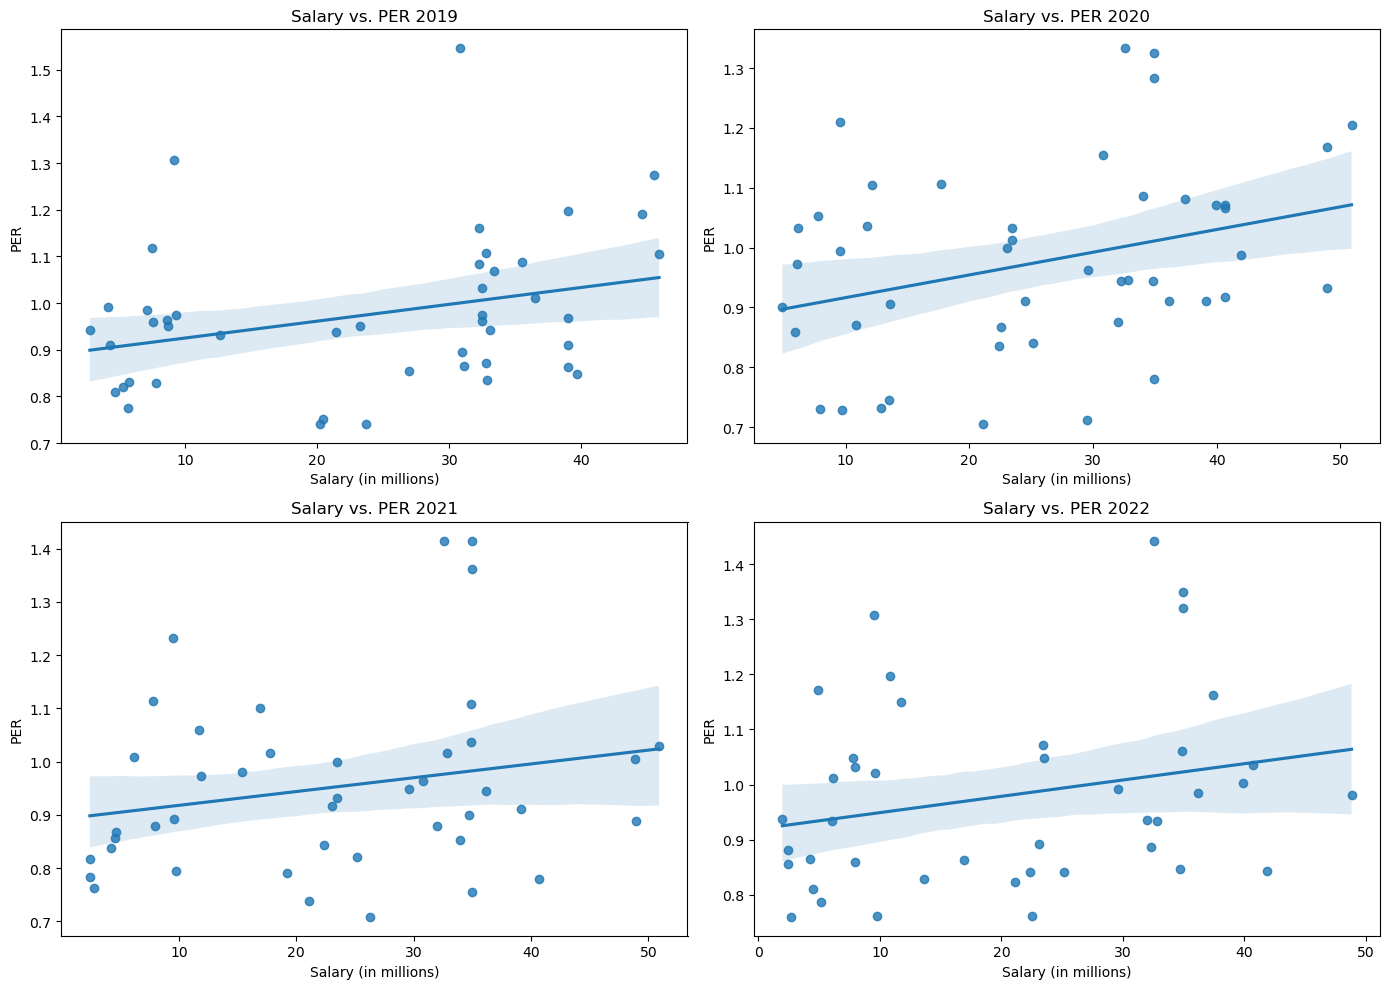

In [63]:
df2019 = pd.read_csv('nba_salaries_2019_2020.csv')
df2020 = pd.read_csv('nba_salaries_2020_2021.csv')
df2021 = pd.read_csv('nba_salaries_2020_2021.csv')
df2022 = pd.read_csv('nba_salaries_2020_2021.csv')
dfs2019 = pd.read_csv('player_stats_2019_2020.csv')
dfs2020 = pd.read_csv('player_stats_2020_2021.csv')
dfs2021 = pd.read_csv('player_stats_2021_2022.csv')
dfs2022 = pd.read_csv('player_stats_2022_2023.csv')
salary = pd.merge(df2019, df2020, on = 'Players', suffixes =('_2019','_2020'))
salary = pd.merge(salary, df2021, on = 'Players', suffixes =('_2020','_2021'))
salary = pd.merge(salary, df2022, on = 'Players', suffixes =('_2021','_2022'))
salary.to_csv('nba_salaries.csv',index=False)
dfs2019 = dfs2019[['Players', 'PER']]
dfs2020 = dfs2020[['Players', 'PER']]
dfs2021 = dfs2021[['Players', 'PER']]
dfs2022 = dfs2022[['Players', 'PER']]
per = pd.merge(dfs2019, dfs2020, on = 'Players', how ='outer', suffixes =('_2019','_2020'))
per = pd.merge(per, dfs2021, on = 'Players', how ='outer', suffixes =('_2020','_2021'))
per = pd.merge(per, dfs2022, on = 'Players', how ='outer',  suffixes =('_2021','_2022'))
per.to_csv('nba_stats.csv',index=False)
all_data = pd.merge(salary, per, on = 'Players')
all_data.to_csv('all_info_nba.csv', index=False)
for year in ['2019', '2020', '2021', '2022']:
    all_data[f'Salaries_{year}'] = all_data[f'Salaries_{year}'].replace({'\$': '', ',': ''}, regex=True).astype(float) / 1000000

descriptive_stats = all_data[['Salaries_2019', 'Salaries_2020', 'Salaries_2021', 'Salaries_2022', 'PER_2019', 'PER_2020', 'PER_2021', 'PER_2022']].describe()
descriptive_stats.to_csv('descriptive_stat_nba.csv',index=False)
plt.figure(figsize=(14, 10))
years = ['2019', '2020', '2021', '2022']
for i, year in enumerate(years):
    plt.subplot(2, 2, i + 1)
    sns.regplot(x=f'Salaries_{year}', y=f'PER_{year}', data=all_data)
    plt.title(f'Salary vs. PER {year}')
    plt.xlabel('Salary (in millions)')
    plt.ylabel('PER')
    plt.ticklabel_format(style='plain', axis='x')  

plt.tight_layout()
plt.show()